### Notebook to analyze total volume transport through the Drake Passage in preindustrial control (piControl) simulations in GFDL models at model's x coordinate to 69W in the Southern Ocean

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
import glob
import os

from dask.distributed import Client 
from dask.distributed import LocalCluster 
cluster = LocalCluster()
client = Client(cluster) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 93.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36777,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 93.91 GiB
Comm: tcp://127.0.0.1:34236,Total threads: 2
Dashboard: http://127.0.0.1:34416/status,Memory: 23.48 GiB
Nanny: tcp://127.0.0.1:43601,


In [2]:
def preprocess(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(10,144))
    return dsnew

## Load model output for GFDL high-res configurations
#### __Odiv-183__: p125, c192. Remap scheme PPM_H4 initialized from year 0. Sea ice initial conditions based on year 100 of v3 rather than year 150.
#### __Odiv-184__: p125, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-170__: p25, c192. Remap scheme PPM_H4 initialized from year 0.
#### __Odiv-191__: p125, c192. Initialized like Odiv-183/184, remap scheme = P1M_H2, submeso MLE decay time = 10 days. Used as baseline experiment to then tune submeso.
#### __Odiv-200__: p125, c192. Sensitivity of submeso parameterization, submeso MLE decay time = 20 days, with everything else the same as Odiv-191
#### __Odiv-206__: p125, c192. Sensitivity experiment with CM4.0 sea ice albedos initialized from year 180 of Odiv-200 run. 
#### __Odiv-207__: p125, c192. Sensitivity experiment with same sea ice albedos as Odiv-206 but with ESM4 snow-on-land albedos values.

#####
##### Note: A longer MLE decay time means the submeso MLE scheme hangs around longer to __more strongly effect restratification__. We adjusted to T=20 days (doubled the decay time) from Odiv-191 to Odiv-200 because we wanted stronger ML restratification to cool the model since we are running an 1850 piControl. In CM4-CMIP6, MLE T=30 days. Another "tunable" submesoscale parameter is MLE front-length scale ... a __smaller__ front length enhances the strength of the ML restratificaion. ESM4 used 200m, CM4 used 500m. All Odiv members use length = 500 m, this has not been adjusted.

In [3]:
def preprocess(ds):
    '''slice in the yh_sub02 dimension first because there is a bug in the cmip6 output'''
    dsnew = ds.isel(yh_sub02=slice(10,144))
    return dsnew

def load_ocean_Drake_Passage_umo(model_config):
    if model_config == 'Odiv-183':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &')
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_v5_proto1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                               combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-184':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &')
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v5/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-170':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &')
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-191':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &')
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-200':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &')
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-206':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &'),
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'Odiv-207':
        os.system('dmget /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc &'),
        ds = xr.open_mfdataset('/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Drake_Passage/ts/monthly/10yr/*umo.nc',
                              combine='by_coords', use_cftime=True)
    if model_config == 'cmip6-cm4':
        ds = xr.open_mfdataset('/net/Rebecca.Beadling/dora_scripts/data/cm4_cmip6/*.umo.nc',
                               combine='by_coords',use_cftime=True,preprocess=preprocess)
    
    return ds

def annual_mean(array):
    """
    weight by days in each month
    """
    # Determine month length
    month_length = array.time.dt.days_in_month
    # Calculate weights
    wgts = month_length.groupby('time.year') / month_length.groupby('time.year').sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Setup our masking for nan values
    cond = array.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    array_sum = (array * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return array_sum / ones_out
    

def east_west(umo_array):
    """
    break umo transport into eastward (+umo) and westward
    components (-umo).
    """
    east = umo_array.where(umo_array > 0)
    west = umo_array.where(umo_array < 0)
    
    return east, west

### Compute annual mean of total volume transport through the Drake Passage

In [6]:
odiv_183_184 = xr.concat([load_ocean_Drake_Passage_umo('Odiv-183'),load_ocean_Drake_Passage_umo('Odiv-184')],dim='time')
odiv_183_184_umo = odiv_183_184.umo
odiv_170_umo = load_ocean_Drake_Passage_umo('Odiv-170').umo
odiv_191_umo = load_ocean_Drake_Passage_umo('Odiv-191').umo
odiv_200_umo = load_ocean_Drake_Passage_umo('Odiv-200').umo
odiv_206_umo = load_ocean_Drake_Passage_umo('Odiv-206').umo
odiv_207_umo = load_ocean_Drake_Passage_umo('Odiv-207').umo
cmip6_cm4_umo = load_ocean_Drake_Passage_umo('cmip6-cm4').umo

odiv_183_184_acc = odiv_183_184_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_170_acc = odiv_170_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_191_acc = odiv_191_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_200_acc = odiv_200_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_206_acc = odiv_206_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_207_acc = odiv_207_umo.sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
cmip6_cm4_acc = cmip6_cm4_umo.sum(dim=['z_l','yh_sub02','xq_sub01'])*(1/1035)*(10**-6)

## Compute annual mean:
odiv_183_184_acc_ann = annual_mean(odiv_183_184_acc).load()
odiv_170_acc_ann = annual_mean(odiv_170_acc).load()
odiv_191_acc_ann = annual_mean(odiv_191_acc).load()
odiv_200_acc_ann = annual_mean(odiv_200_acc).load()
odiv_206_acc_ann = annual_mean(odiv_206_acc).load()
odiv_207_acc_ann = annual_mean(odiv_207_acc).load()
cmip6_cm4_acc_ann = annual_mean(cmip6_cm4_acc).load()

### Plot of total volume transport through the Drake Passage with observational estimates overlaid

Text(0.92, 0.55, 'Xu et al. 2020 (1/12th HYCOM)')

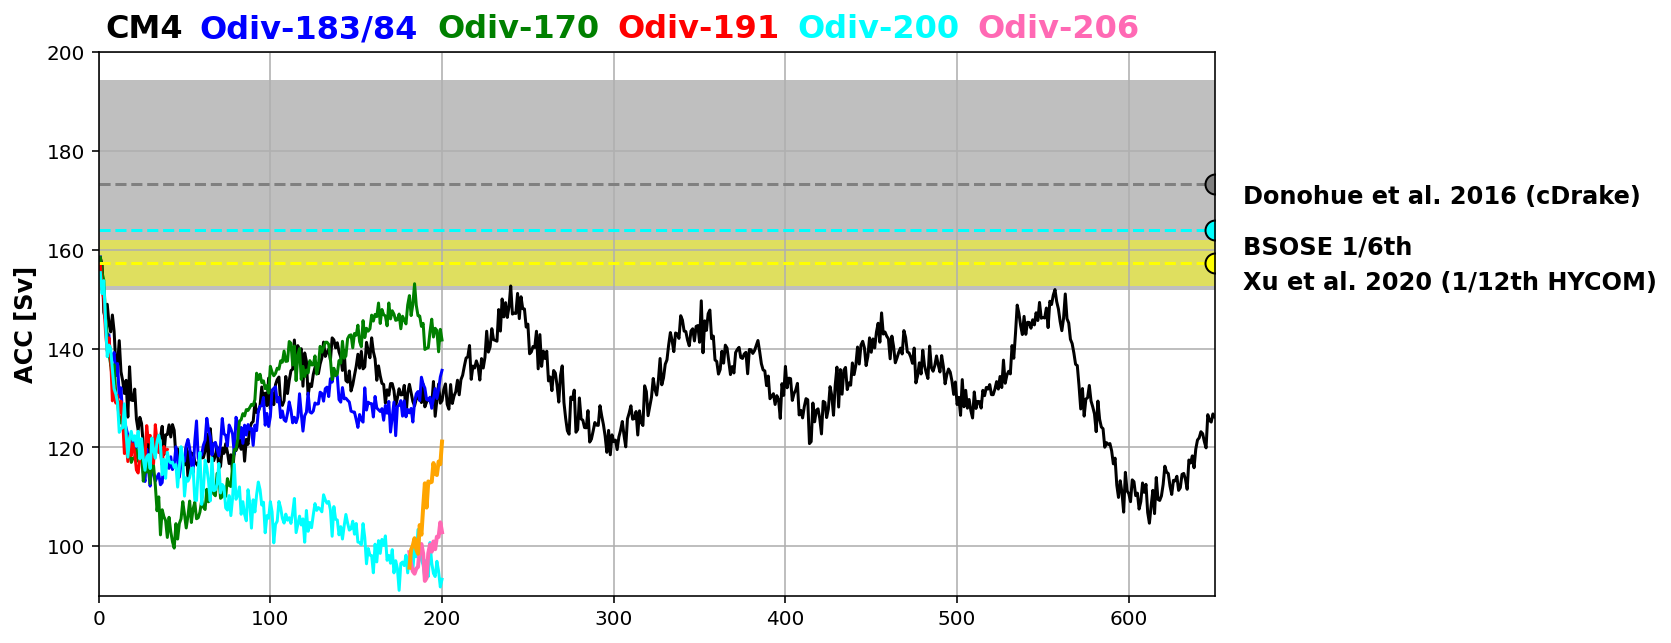

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cmip6_cm4_acc_ann.time.dt.year,cmip6_cm4_acc_ann.values,color='black')
plt.plot(odiv_183_184_acc_ann.time.dt.year,odiv_183_184_acc_ann.values,color='blue')
plt.plot(odiv_170_acc_ann.time.dt.year,odiv_170_acc_ann.values,color='green')
plt.plot(odiv_191_acc_ann.time.dt.year,odiv_191_acc_ann.values,color='red')
plt.plot(odiv_200_acc_ann.time.dt.year,odiv_200_acc_ann.values,color='cyan')
plt.plot(odiv_206_acc_ann.time.dt.year,odiv_206_acc_ann.values,color='hotpink',linewidth=2)
plt.plot(odiv_207_acc_ann.time.dt.year,odiv_207_acc_ann.values,color='orange',linewidth=2)

x_end = 650
x_Donohue = (0,650)
y1_Donohue = (151.9)
y2_Donohue = (194.4)
y3_Donohue = (173.3)

y_Xu2020 = (157.3)
y1_Xu2020 = (161.9)
y2_Xu2020 = (152.7)

y_BSOSE = (164)

ax.fill_between(x_Donohue,y1_Donohue,y2_Donohue,facecolor='grey',alpha=0.5)
ax.fill_between(x_Donohue,y1_Xu2020,y2_Xu2020,facecolor='yellow',alpha=0.5)

ax.set_ylabel('ACC [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(90,200)
plt.xlim(0,650)
plt.axhline(y=173.3,linestyle='--',color='grey')
plt.axhline(y=164,linestyle='--',color='cyan')
plt.axhline(y=157.3,linestyle='--',color='yellow')
ax.set_title('')

plt.plot(x_end,
         y3_Donohue,
         marker='o',
         markersize=10,
         markerfacecolor='grey',
         markeredgecolor='k')
plt.plot(x_end,
         y_BSOSE,
         marker='o',
         markersize=10,
         markerfacecolor='cyan',
         markeredgecolor='k')
plt.plot(x_end,
         y_Xu2020,
         marker='o',
         markersize=10,
         markerfacecolor='yellow',
         markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.92,0.67,'Donohue et al. 2016 (cDrake)',fontsize=12,color='black',fontweight='bold')
fig.text(0.92,0.60,'BSOSE 1/6th',fontsize=12,color='black',fontweight='bold')
fig.text(0.92,0.55,'Xu et al. 2020 (1/12th HYCOM)',fontsize=12,color='black',fontweight='bold')

### Plot of total volume transport through the Drake Passage in upper 1000 m with observational estimates overlaid

In [8]:
odiv_183_184_acc_1k = odiv_183_184_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_170_acc_1k = odiv_170_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_191_acc_1k = odiv_191_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_200_acc_1k = odiv_200_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_206_acc_1k = odiv_206_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_207_acc_1k = odiv_207_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
cmip6_cm4_acc_1k = cmip6_cm4_umo.sel(z_l=slice(0,1000)).sum(dim=['z_l','yh_sub02','xq_sub01'])*(1/1035)*(10**-6)

## Compute annual mean:
odiv_183_184_acc_1k_ann = annual_mean(odiv_183_184_acc_1k).load()
odiv_170_acc_1k_ann = annual_mean(odiv_170_acc_1k).load()
odiv_191_acc_1k_ann = annual_mean(odiv_191_acc_1k).load()
odiv_200_acc_1k_ann = annual_mean(odiv_200_acc_1k).load()
odiv_206_acc_1k_ann = annual_mean(odiv_206_acc_1k).load()
odiv_207_acc_1k_ann = annual_mean(odiv_207_acc_1k).load()
cmip6_cm4_acc_1k_ann = annual_mean(cmip6_cm4_acc_1k).load()

Text(0.92, 0.67, 'Firing et al. 2011 (SADCP)')

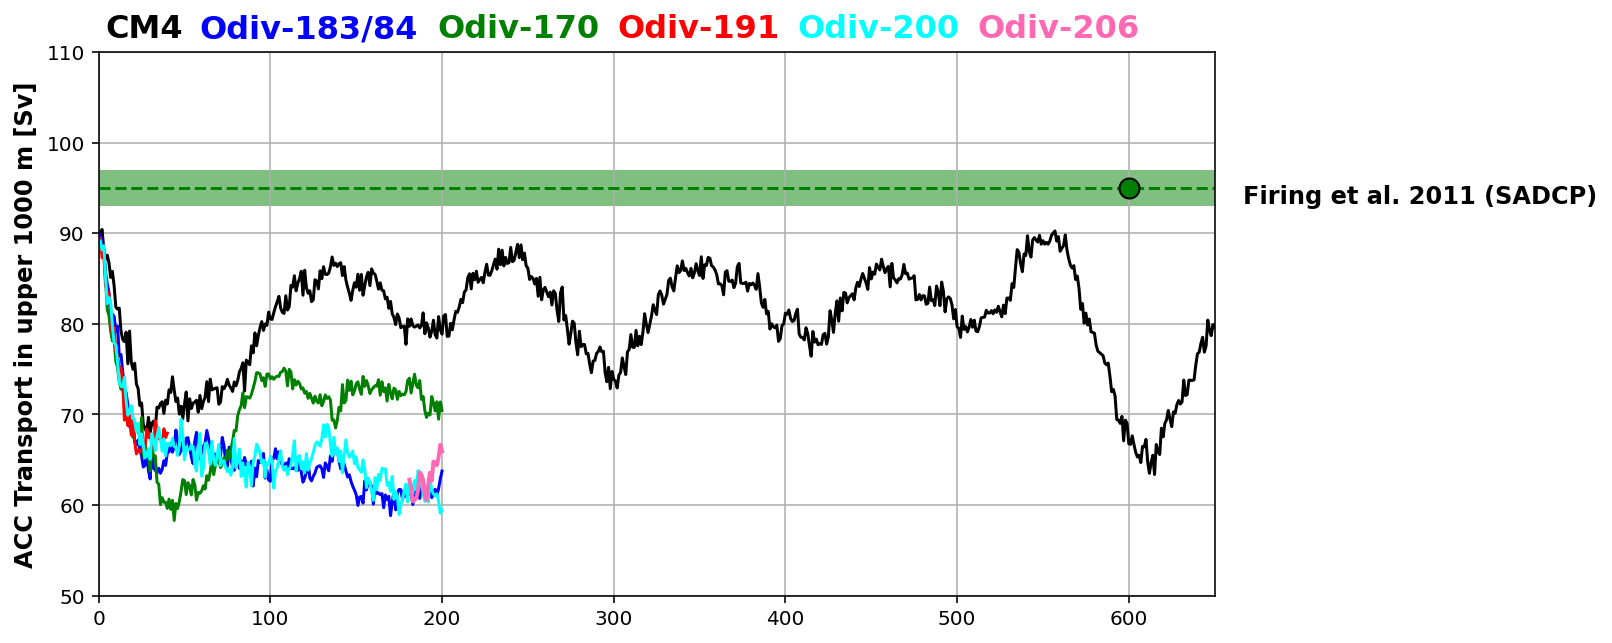

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cmip6_cm4_acc_ann.time.dt.year,cmip6_cm4_acc_1k_ann.values,color='black')
plt.plot(odiv_183_184_acc_ann.time.dt.year,odiv_183_184_acc_1k_ann.values,color='blue')
plt.plot(odiv_170_acc_ann.time.dt.year,odiv_170_acc_1k_ann.values,color='green')
plt.plot(odiv_191_acc_ann.time.dt.year,odiv_191_acc_1k_ann.values,color='red')
plt.plot(odiv_200_acc_ann.time.dt.year,odiv_200_acc_1k_ann.values,color='cyan')
plt.plot(odiv_206_acc_ann.time.dt.year,odiv_206_acc_1k_ann.values,color='hotpink',linewidth=2)
plt.plot(odiv_207_acc_ann.time.dt.year,odiv_207_acc_1k_ann.values,color='orange',linewidth=2)

x_end = 600

x_all = (0,650)
y_Firing = (95)
y1_Firing = (93)
y2_Firing = (97)


ax.fill_between(x_all,y1_Firing,y2_Firing,facecolor='green',alpha=0.5)

ax.set_ylabel('ACC Transport in upper 1000 m [Sv]',fontweight='bold',fontsize='large')
plt.grid()
plt.ylim(50,110)
plt.xlim(0,650)
plt.axhline(y=95,linestyle='--',color='green')

plt.plot(x_end,y_Firing,marker='o',markersize=10,markerfacecolor='green',markeredgecolor='k')

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')

fig.text(0.92,0.67,'Firing et al. 2011 (SADCP)',fontsize=12,color='black',fontweight='bold')

### Break flow into eastward and westward components

In [7]:
odiv_183_184_acc_east = (east_west(odiv_183_184_umo)[0]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_183_184_acc_west = (east_west(odiv_183_184_umo)[1]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6) 
odiv_170_acc_east = (east_west(odiv_170_umo)[0]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_170_acc_west = (east_west(odiv_170_umo)[1]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6) 
odiv_191_acc_east = (east_west(odiv_191_umo)[0]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_191_acc_west = (east_west(odiv_191_umo)[1]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6) 
odiv_200_acc_east = (east_west(odiv_200_umo)[0]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_200_acc_west = (east_west(odiv_200_umo)[1]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6) 
odiv_206_acc_east = (east_west(odiv_206_umo)[0]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6)
odiv_206_acc_west = (east_west(odiv_206_umo)[1]).sum(dim=['z_l','yh_sub01','xq_sub01'])*(1/1035)*(10**-6) 
odiv_cmip6_cm4_acc_east = (east_west(cmip6_cm4_umo)[0]).sum(dim=['z_l','yh_sub02','xq_sub01'])*(1/1035)*(10**-6)
odiv_cmip6_cm4_acc_west = (east_west(cmip6_cm4_umo)[1]).sum(dim=['z_l','yh_sub02','xq_sub01'])*(1/1035)*(10**-6)

## Compute annual mean:
odiv_183_184_acc_east_ann = annual_mean(odiv_183_184_acc_east).load()
odiv_183_184_acc_west_ann = annual_mean(odiv_183_184_acc_west).load()
odiv_170_acc_east_ann = annual_mean(odiv_170_acc_east).load()
odiv_170_acc_west_ann = annual_mean(odiv_170_acc_west).load()
odiv_191_acc_east_ann = annual_mean(odiv_191_acc_east).load()
odiv_191_acc_west_ann = annual_mean(odiv_191_acc_west).load()
odiv_200_acc_east_ann = annual_mean(odiv_200_acc_east).load()
odiv_200_acc_west_ann = annual_mean(odiv_200_acc_west).load()
odiv_206_acc_east_ann = annual_mean(odiv_206_acc_east).load()
odiv_206_acc_west_ann = annual_mean(odiv_206_acc_west).load()
odiv_cmip6_cm4_acc_east_ann = annual_mean(odiv_cmip6_cm4_acc_east).load()
odiv_cmip6_cm4_acc_west_ann = annual_mean(odiv_cmip6_cm4_acc_west).load()

Text(0.735, 0.9, 'Odiv-206')

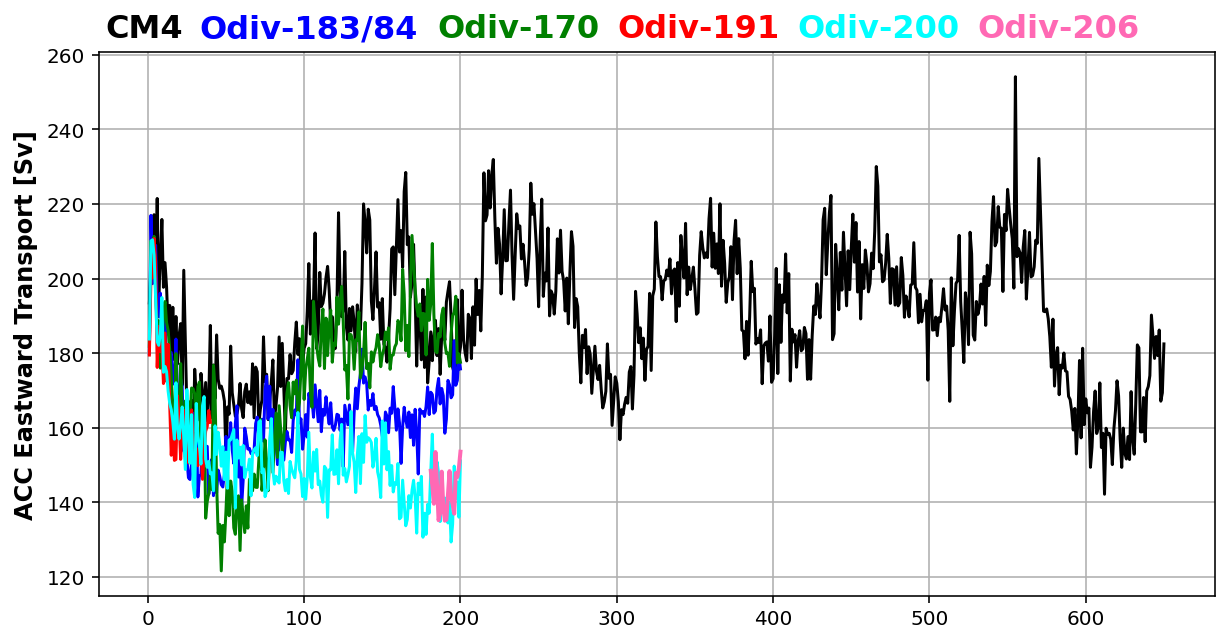

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cmip6_cm4_acc_ann.time.dt.year,odiv_cmip6_cm4_acc_east_ann.values,color='black')
plt.plot(odiv_183_184_acc_ann.time.dt.year,odiv_183_184_acc_east_ann.values,color='blue')
plt.plot(odiv_170_acc_ann.time.dt.year,odiv_170_acc_east_ann.values,color='green')
plt.plot(odiv_191_acc_ann.time.dt.year,odiv_191_acc_east_ann.values,color='red')
plt.plot(odiv_200_acc_ann.time.dt.year,odiv_200_acc_east_ann.values,color='cyan')
plt.plot(odiv_206_acc_ann.time.dt.year,odiv_206_acc_east_ann.values,color='hotpink',linewidth=2)

ax.set_ylabel('ACC Eastward Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')

Text(0.735, 0.9, 'Odiv-206')

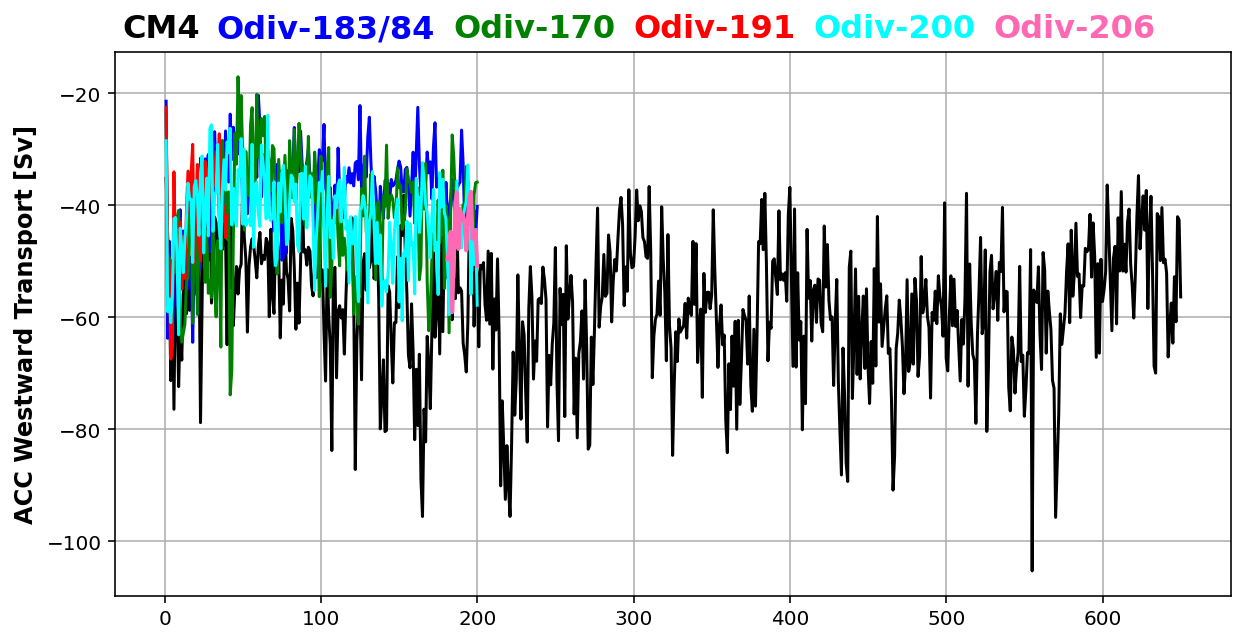

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

plt.plot(cmip6_cm4_acc_ann.time.dt.year,odiv_cmip6_cm4_acc_west_ann.values,color='black')
plt.plot(odiv_183_184_acc_ann.time.dt.year,odiv_183_184_acc_west_ann.values,color='blue')
plt.plot(odiv_170_acc_ann.time.dt.year,odiv_170_acc_west_ann.values,color='green')
plt.plot(odiv_191_acc_ann.time.dt.year,odiv_191_acc_west_ann.values,color='red')
plt.plot(odiv_200_acc_ann.time.dt.year,odiv_200_acc_west_ann.values,color='cyan')
plt.plot(odiv_206_acc_ann.time.dt.year,odiv_206_acc_west_ann.values,color='hotpink',linewidth=2)

ax.set_ylabel('ACC Westward Transport [Sv]',fontweight='bold',fontsize='large')
plt.grid()

fig.text(0.13,0.90,'CM4',fontsize=16,color='k',fontweight='bold')
fig.text(0.195,0.90,'Odiv-183/84',fontsize=16,color='blue',fontweight='bold')
fig.text(0.36,0.90,'Odiv-170',fontsize=16,color='green',fontweight='bold')
fig.text(0.485,0.90,'Odiv-191',fontsize=16,color='red',fontweight='bold')
fig.text(0.61,0.90,'Odiv-200',fontsize=16,color='cyan',fontweight='bold')
fig.text(0.735,0.90,'Odiv-206',fontsize=16,color='hotpink',fontweight='bold')